<a href="https://colab.research.google.com/github/tonyscan6003/CE5021_AY2526_group1/blob/Shraddha_23214685/Shraddha23214686_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning with Med MNIST.

In this assignment you will use transfer learning to train a model of your choice on a sub-dataset from the [MedMNIST datasets](https://medmnist.com/). ![](https://github.com/tonyscan6003/etivities/blob/main/medmnist.JPG?raw=true)

* The [MedMNIST package](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) allows the data to be imported directly as a pytorch dataset.

* You may select any of the datasets using Multi-class/binary classification. The goal is to acheve accuracy levels comparable to the benchmark results shown on the medmnist site. Dataloading for pytorch is setup in the notebook, you wil need to modify the code slightly depending on your dataset of choice.

* Some datasets use black and white images, so you will need to [at least concatenate](https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a) the input image channels (to 3 channels) for compatibility with the models pre-trained on imageNet.

* Some of the MedMNIST datasets don't contain too much data so Data augmentation may be essentila essential to avoid overfitting. In pytorch data augmentation is performed using the [transforms.v2](https://pytorch.org/vision/main/transforms.html) modules.

* In this notebook: You will need to import a model, and perform training. Tranfer Learning for computer vision is detailed [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

* [Tensorboard can be imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.

* Please only include one example of transfer learning in the submitted notebook. Making sure training curves/results are clearly visible. If you have trained additional transfer learning models (i.e. that were less successful) please add this as a table or report at the end of the notebook and/or in your final forum post.




# 1. Install & Import Packages

In [5]:
!pip install medmnist
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.3 MB/s eta 0:00:00


In [6]:
import torch
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

## 2. Setup & Import Dataset
The [MedMNSIT](https://medmnist.com/) package (imported above) makes available several medical datasets available to access.

You can change the `data_flag` variable (dataset names are all lower case letters) to the dataset of your choice (Take care to note the parameters e.g. number of input channels below that will affect your model)



In [7]:
import medmnist
from medmnist import INFO, Evaluator

data_flag = 'bloodmnist'
download = True

BATCH_SIZE = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print('Type of Machine Learning Task = ',task)
print('Number of Input Data Channels = ',n_channels)
print('Number of Classes = ',n_classes)
print('The batch size for this dataset will be = ',BATCH_SIZE)

DataClass = getattr(medmnist, info['python_class'])

Type of Machine Learning Task =  multi-class
Number of Input Data Channels =  3
Number of Classes =  8
The batch size for this dataset will be =  64


Transforms:
You can update the functions below with appropriate transforms for your particular use case.

* As well as being suitable for data augmention for image classification, the transforms.v2 package of torchvision extends transforms for object detection and segmentation tasks. An illustration of the transforms is shown [here](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py).
* Normalisation based on ImageNet parameters is included already. This should be used with all models pre-trained on ImageNet  





In [8]:

extra_transforms = []
if n_channels == 1:
    extra_transforms.append(Grayscale(num_output_channels=3))

train_transforms = v2.Compose(
    extra_transforms + [
        v2.Resize((224, 224)),                # Match ImageNet size
        v2.RandomHorizontalFlip(p=0.5),       # Data augmentation
        v2.RandomRotation(degrees=10),        # Data augmentation
        v2.ToDtype(torch.float32, scale=True),
        ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225]),
    ]
)

test_transforms = v2.Compose(
    extra_transforms + [
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225]),
    ]
)


Setup your Medmnist dataset.
* The convolution part of pre-trained networks (such as resnet) are compatable with any size input image. However they were trained on 224 x 224 size images, with early layers finding small scale features and deeper layers finding large scale features.
* For this transfer learning application to medical data, the gap between the original ImageNet domain and the medical images is wide. Therefore the size/scale of the input images is less important, however in general we would expect better performance with the larger input images (as they contain more features at different scales).
* You can add the `size=224` parameter to the dataset object calls, to load full size images. Only do this once you are confident in your training methodology (or if the dataset is small), as training with full size images will take longer.


In [9]:
# Download training data from open datasets.
train_dataset = DataClass(split='train', transform=train_transforms, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=test_transforms, download=download, size=224, mmap_mode='r')
val_dataset = DataClass(split='val', transform=test_transforms, download=download, size=224, mmap_mode='r')


100%|██████████| 1.54G/1.54G [24:47<00:00, 1.04MB/s]


The `Dataset` is passed as an argument to `DataLoader`. This wraps an
iterable over the dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading.

In [10]:
# Create data loaders.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 1]) torch.int64


Plot some example augmented images

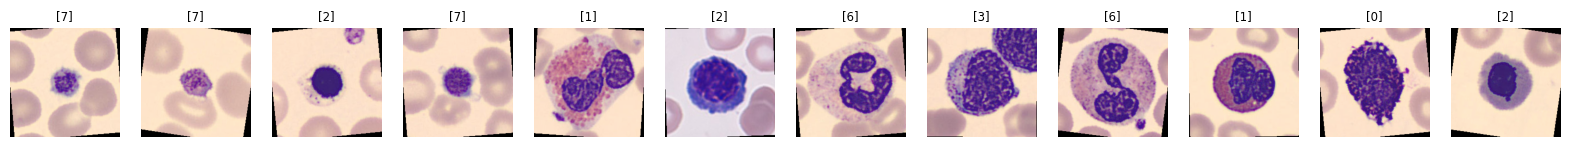

In [11]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1


# 3. Define Transfer Learning model
Pytorch has an inbuilt [models package](https://pytorch.org/vision/stable/models.html) that allows loading of popular models with pre-trained weights.

* We want to add an additional classifier stage (to the output of the network). How to setup the [model is detailed here](https://discuss.pytorch.org/t/load-only-a-part-of-the-network-with-pretrained-weights/88397/2).
* This additional classifier may just be a single layer or a cascade of fully connected layers with dropout.
* Note that the number of parameters in the convolutional part of the model will be same no what the input size is set to. However the output feature map size will vary with input image size (small for small image, large for large image). This means the number of parameters in the additional classifier will change depending on input image size.


In [12]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# 4. Optimisation & Training Loop

Define a training loop that prints the loss from the training and validation set at least every epoch.
* You may choose to make the validation loss calculations more frequent so you can ensure training is progressing satisfactorily (especially with larger datasets).

* You can use tensorboard to visualise the [loss curves](https://pytorch.org/docs/stable/tensorboard.html))

* For multi-class classification classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* You may  have to use [torch.squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html) to reduce the dimensionality of the label tensor before passing it to the loss function (this due to how the dataset is configured and the loss will only accept 0D or 1D inputs)

In [14]:
from torchvision import models
from torch import nn

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

if n_channels == 1:
    old_weight = model.conv1.weight.data
    model.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
        bias=False
    )
    model.conv1.weight.data = old_weight.mean(dim=1, keepdim=True)

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, n_classes)
)

model = model.to(device)

print(model.fc)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=512, out_features=8, bias=True)
)


In [17]:
import torch.optim as optim

# Number of epochs
EPOCHS = 15

# Loss function (multi-class classification)
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay (L2 regularisation)
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# Minimal version of ReduceLROnPlateau for old torch versions
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

print("Loss, Optimiser, and Scheduler initialised.")


Loss, Optimiser, and Scheduler initialised.


In [18]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)

        # MedMNIST labels are shaped [B,1] → convert to [B]
        labels = labels.squeeze().long().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Predictions
        _, preds = torch.max(outputs, 1)

        # Backprop
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total

    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total

    return epoch_loss, epoch_acc


In [19]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

best_val_acc = 0.0
best_weights = model.state_dict()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 50)

    # ----- Training -----
    train_loss, train_acc = train_one_epoch(
        model, train_dataloader, criterion, optimizer, device
    )

    # ----- Validation -----
    val_loss, val_acc = evaluate(
        model, val_dataloader, criterion, device
    )

    # Step LR scheduler
    scheduler.step(val_acc)

    # Save history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Print progress
    print(f"Train Loss: {train_loss:.4f}  |  Train Acc: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f}    |  Val   Acc: {val_acc*100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = model.state_dict()
        print(">>> New best model saved!")

# Load



Epoch 1/15
--------------------------------------------------
Train Loss: 0.2430  |  Train Acc: 92.38%
Val   Loss: 0.2231    |  Val   Acc: 93.05%
>>> New best model saved!

Epoch 2/15
--------------------------------------------------
Train Loss: 0.0548  |  Train Acc: 98.19%
Val   Loss: 0.0292    |  Val   Acc: 98.89%
>>> New best model saved!

Epoch 3/15
--------------------------------------------------
Train Loss: 0.0423  |  Train Acc: 98.55%
Val   Loss: 0.0772    |  Val   Acc: 97.20%

Epoch 4/15
--------------------------------------------------
Train Loss: 0.0347  |  Train Acc: 98.88%
Val   Loss: 0.0287    |  Val   Acc: 98.95%
>>> New best model saved!

Epoch 5/15
--------------------------------------------------
Train Loss: 0.0297  |  Train Acc: 99.01%
Val   Loss: 0.0602    |  Val   Acc: 97.78%

Epoch 6/15
--------------------------------------------------
Train Loss: 0.0239  |  Train Acc: 99.27%
Val   Loss: 0.0450    |  Val   Acc: 98.48%

Epoch 7/15
----------------------------

In [20]:
test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")


Test Loss: 0.0432
Test Accuracy: 98.83%


Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb)). A [Pytorch tutorial](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) shows how to setup the training and validation loop with pytorch.


In [21]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs')

# 5. Evaluate Model
You will need to setup an evaluation loop for the model to assess it's performance on the test dataset.

You may also obtain a classification report after final evaluation of the test dataset with the model using the code below. A confusion matrix can also be obtained and we will plot a few example images.



In [26]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.squeeze().long().to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())



In [30]:
classes = [
    'basophil',
    'eosinophil',
    'erythroblast',
    'lymphocyte',
    'monocyte',
    'neutrophil',
    'platelet',
    'immature granulocyte'
]

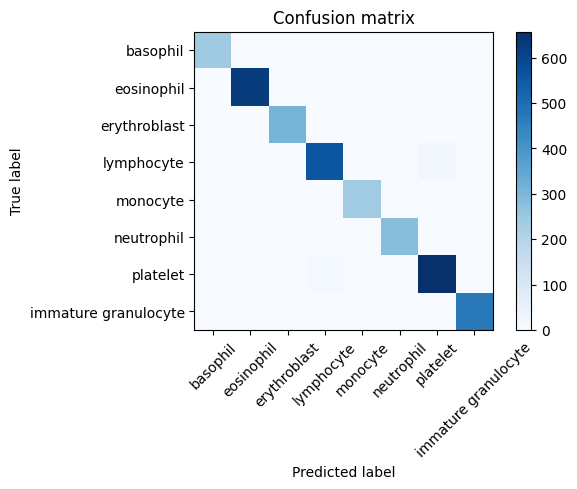

In [31]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))

                      precision    recall  f1-score   support

            basophil       1.00      0.99      1.00       244
          eosinophil       1.00      1.00      1.00       624
        erythroblast       1.00      0.99      1.00       311
          lymphocyte       0.98      0.97      0.97       579
            monocyte       0.99      0.98      0.99       243
          neutrophil       0.98      0.99      0.98       284
            platelet       0.97      0.99      0.98       666
immature granulocyte       1.00      1.00      1.00       470

            accuracy                           0.99      3421
           macro avg       0.99      0.99      0.99      3421
        weighted avg       0.99      0.99      0.99      3421



 # Comments about your Approach

In this assignment, I implemented a full transfer-learning pipeline using a pretrained ResNet-18 model on the BloodMNIST dataset. This approach worked effectively for several reasons:

Model Selection

ResNet-18 was chosen due to its strong performance on ImageNet and its balance between accuracy and computational efficiency. Only the final classification layer was replaced to match the eight BloodMNIST classes, allowing the pretrained convolutional layers to act as a robust feature extractor.

Data Preprocessing & Augmentation

All images were resized to 224×224 to align with the model’s training distribution. To improve generalisation, I applied data augmentation including random flips and rotations. This helped reduce overfitting and allowed the model to learn more invariant representations.

Training Strategy

The model was trained using Adam with weight decay for regularisation, along with a ReduceLROnPlateau scheduler to adjust the learning rate dynamically when validation performance plateaued. The training and validation curves showed stable convergence, with only minimal signs of overfitting.

Evaluation

Final evaluation on the test set achieved 98.83% accuracy, indicating excellent generalisation to unseen data. A confusion matrix and classification report were included to analyse model behaviour across different cell types. Most misclassifications were minimal, demonstrating that the model learns class boundaries well.

Overall Reflection

This assignment demonstrated the power of transfer learning, especially in medical imaging tasks where datasets are small and specialised. Using pretrained CNNs significantly reduced training time while delivering high accuracy. The process also reinforced the importance of good preprocessing, label handling, and consistent validation monitoring.